# 0. Технические моменты

In [ ]:
# Зависимости не дружат, приходится переустанавливать отдельно
%pip install --no-deps scikit-mobility==1.3.1 geopandas==1.1.0 -qq

# Pipeline
Ниже пошаговый пайплайн: параметры → население → матрицы → анализ → PNG-карта.


In [1]:
import pandas as pd
from changer_migration.model import MigrationFlowModel


In [ ]:
import pandas as pd
import geopandas as gpd
from townsnet.provision import ProvisionModel, ServiceType

d:\programming\github\changer-migration-model\.venv\lib\site-packages\pandera\_pandas_deprecated.py:160: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [10]:
service_types = pd.read_json('service_types.json')
services = gpd.read_file('services.geojson')
towns = gpd.read_file('towns.geojson')
acc_mx = pd.read_json('accessibility_matrix.json')

In [7]:
provisionModel = ProvisionModel(towns_gdf=towns, acc_mx=acc_mx, max_depth=1)

In [12]:
services

,town,service_type,capacity,geometry
0,Бор,kindergarten,250,POINT (545062.236 6592984.549)
1,Бор,school,250,POINT (545003.453 6592946.638)
2,Бор,cafe__coffee,250,POINT (545057.111 6593074.763)
3,Дмитрово,public_transport_stop,250,POINT (556606.517 6570799.269)
4,Ларьян,school,250,POINT (543946.962 6596292.051)
...,...,...,...,...
26597,Апраксин Бор,public_transport_stop,250,POINT (399227.549 6560566.367)
26598,Апраксин Бор,public_transport_stop,250,POINT (399216.723 6560632.806)
26599,Большая Горка,public_transport_stop,250,POINT (413170.857 6573826.061)
26600,Большая Горка,parking,250,POINT (413177.392 6573887.703)


In [25]:
service_types

,category,infrastructure,name,name_ru,weight,accessibility,demand
0,BASIC,EDUCATION,kindergarten,детский сад,0.20,7,61
1,BASIC,EDUCATION,school,школа,0.20,15,120
2,BASIC,HEALTHCARE,health_center__dispensary,ФАП / амбулатория,0.20,10,13
3,BASIC,HEALTHCARE,pharmacy,аптека,0.20,15,15
4,BASIC,COMMERCE,convenience,продуктовый магазин,0.20,5,180
5,BASIC,COMMERCE,houseware,хозяйственный магазин,0.20,5,180
6,BASIC,CATERING,cafe__coffee,кафе / кофейня,0.15,15,25
7,BASIC,LEISURE,universal_hall,универсальный зал,0.10,15,180
8,BASIC,RECREATION,playground,детская площадка,0.20,4,2
9,BASIC,RECREATION,square__boulevard__forest_park,сквер / бульвар / лесопарк,0.20,30,150


In [19]:
services

,town,service_type,capacity,geometry
0,Бор,kindergarten,250,POINT (545062.236 6592984.549)
1,Бор,school,250,POINT (545003.453 6592946.638)
2,Бор,cafe__coffee,250,POINT (545057.111 6593074.763)
3,Дмитрово,public_transport_stop,250,POINT (556606.517 6570799.269)
4,Ларьян,school,250,POINT (543946.962 6596292.051)
...,...,...,...,...
26597,Апраксин Бор,public_transport_stop,250,POINT (399227.549 6560566.367)
26598,Апраксин Бор,public_transport_stop,250,POINT (399216.723 6560632.806)
26599,Большая Горка,public_transport_stop,250,POINT (413170.857 6573826.061)
26600,Большая Горка,parking,250,POINT (413177.392 6573887.703)


In [21]:
services_df = services.groupby(['town', 'service_type'])['capacity']\
          .sum()\
          .reset_index()\
          .sort_values('capacity', ascending=False)

services_df.rename(columns={'capacity': 'supply'}, inplace=True)

In [23]:
services_df[services_df['service_type'] == 'kindergarten']

,town,service_type,supply
2930,Мурино,kindergarten,13000
950,Гатчина,kindergarten,6750
792,Выборг,kindergarten,6000
750,Всеволожск,kindergarten,5500
2201,Кудрово,kindergarten,5250
...,...,...,...
2484,Лехтуси,kindergarten,250
2547,Лопухинка,kindergarten,250
2559,Лосево,kindergarten,250
2433,Ленинское,kindergarten,250


In [24]:
provisionModel.calculate(services_df[services_df['service_type'] == 'kindergarten'], service_type='kindergarten')

AttributeError: 'str' object has no attribute 'supply_value'

In [2]:
UPDATED = True  # если True — использовать новое население

MATRIX_DIR = 'data/provision/new' if UPDATED else 'data/provision/old' # каталог с *_links.parquet
REGION_PKL = "data/lo_region.pickle" # pickle с Region
PNG_OUT = 'data/examples/anchor_flow_map.png'
SEED = 42

region = MigrationFlowModel.from_pickle(REGION_PKL, seed=SEED)

In [3]:
region.model.get_services_gdf().to_file('services.geojson')

In [ ]:
# 2) Население
population = pd.read_csv('data/population_new.csv') if UPDATED else pd.read_csv('data/population.csv')
region.update_population(population)


In [ ]:
# 2.1) Если нет готовых матриц для населения, то его необходимо расчитать
region.calculate_provision(region.services.service_type.unique(), data_path='data/provision/new', n_jobs=1)


In [ ]:
# 3) Загрузка матрицы перемещений
anchor_settlement = pd.read_csv('data/anchor_settlement.csv') # Города/деревни ЛО
region.load_migration_matrix(matrix_dir=MATRIX_DIR,
                             average=False,
                             anchors=anchor_settlement)


In [25]:
# 4) Анализ мобильности и опорных пунктов
mobilities = region.analyze_mobility(anchor_threshold=90)

In [26]:
region.city_json[121]

{'Название': 'Бокситогорск',
 'Опорный пункт': True,
 'Потенциальный опорный пункт': False,
 'Население': 20200,
 'Самообеспеченность, %': 99.23762,
 'Градообслуживающие функции': {'Безопасность': {'доля, %': 99.24,
   'население': 20046},
  'Здравоохранение': {'доля, %': 99.87, 'население': 20174},
  'Культура': {'доля, %': 98.8, 'население': 19957},
  'Образование': {'доля, %': 97.81, 'население': 19757},
  'Спорт': {'доля, %': 100.0, 'население': 20200},
  'Туризм': {'доля, %': 98.74, 'население': 19945},
  'Услуги': {'доля, %': 99.24, 'население': 20046}},
 'Градообразующие функции': {'Безопасность': {'приток': 69.0, 'доля, %': 5.09},
  'Здравоохранение': {'приток': 391.0, 'доля, %': 28.86},
  'Культура': {'приток': 26.0, 'доля, %': 1.92},
  'Образование': {'приток': 267.0, 'доля, %': 19.7},
  'Спорт': {'приток': 293.0, 'доля, %': 21.62},
  'Туризм': {'приток': 0.0, 'доля, %': 0.0},
  'Услуги': {'приток': 309.0, 'доля, %': 22.8}},
 'Наиважнейшая градообразующая функция': 'Здравоохр

In [ ]:
# 5.1) Динамическая карта
fmap = region.create_map()
fmap

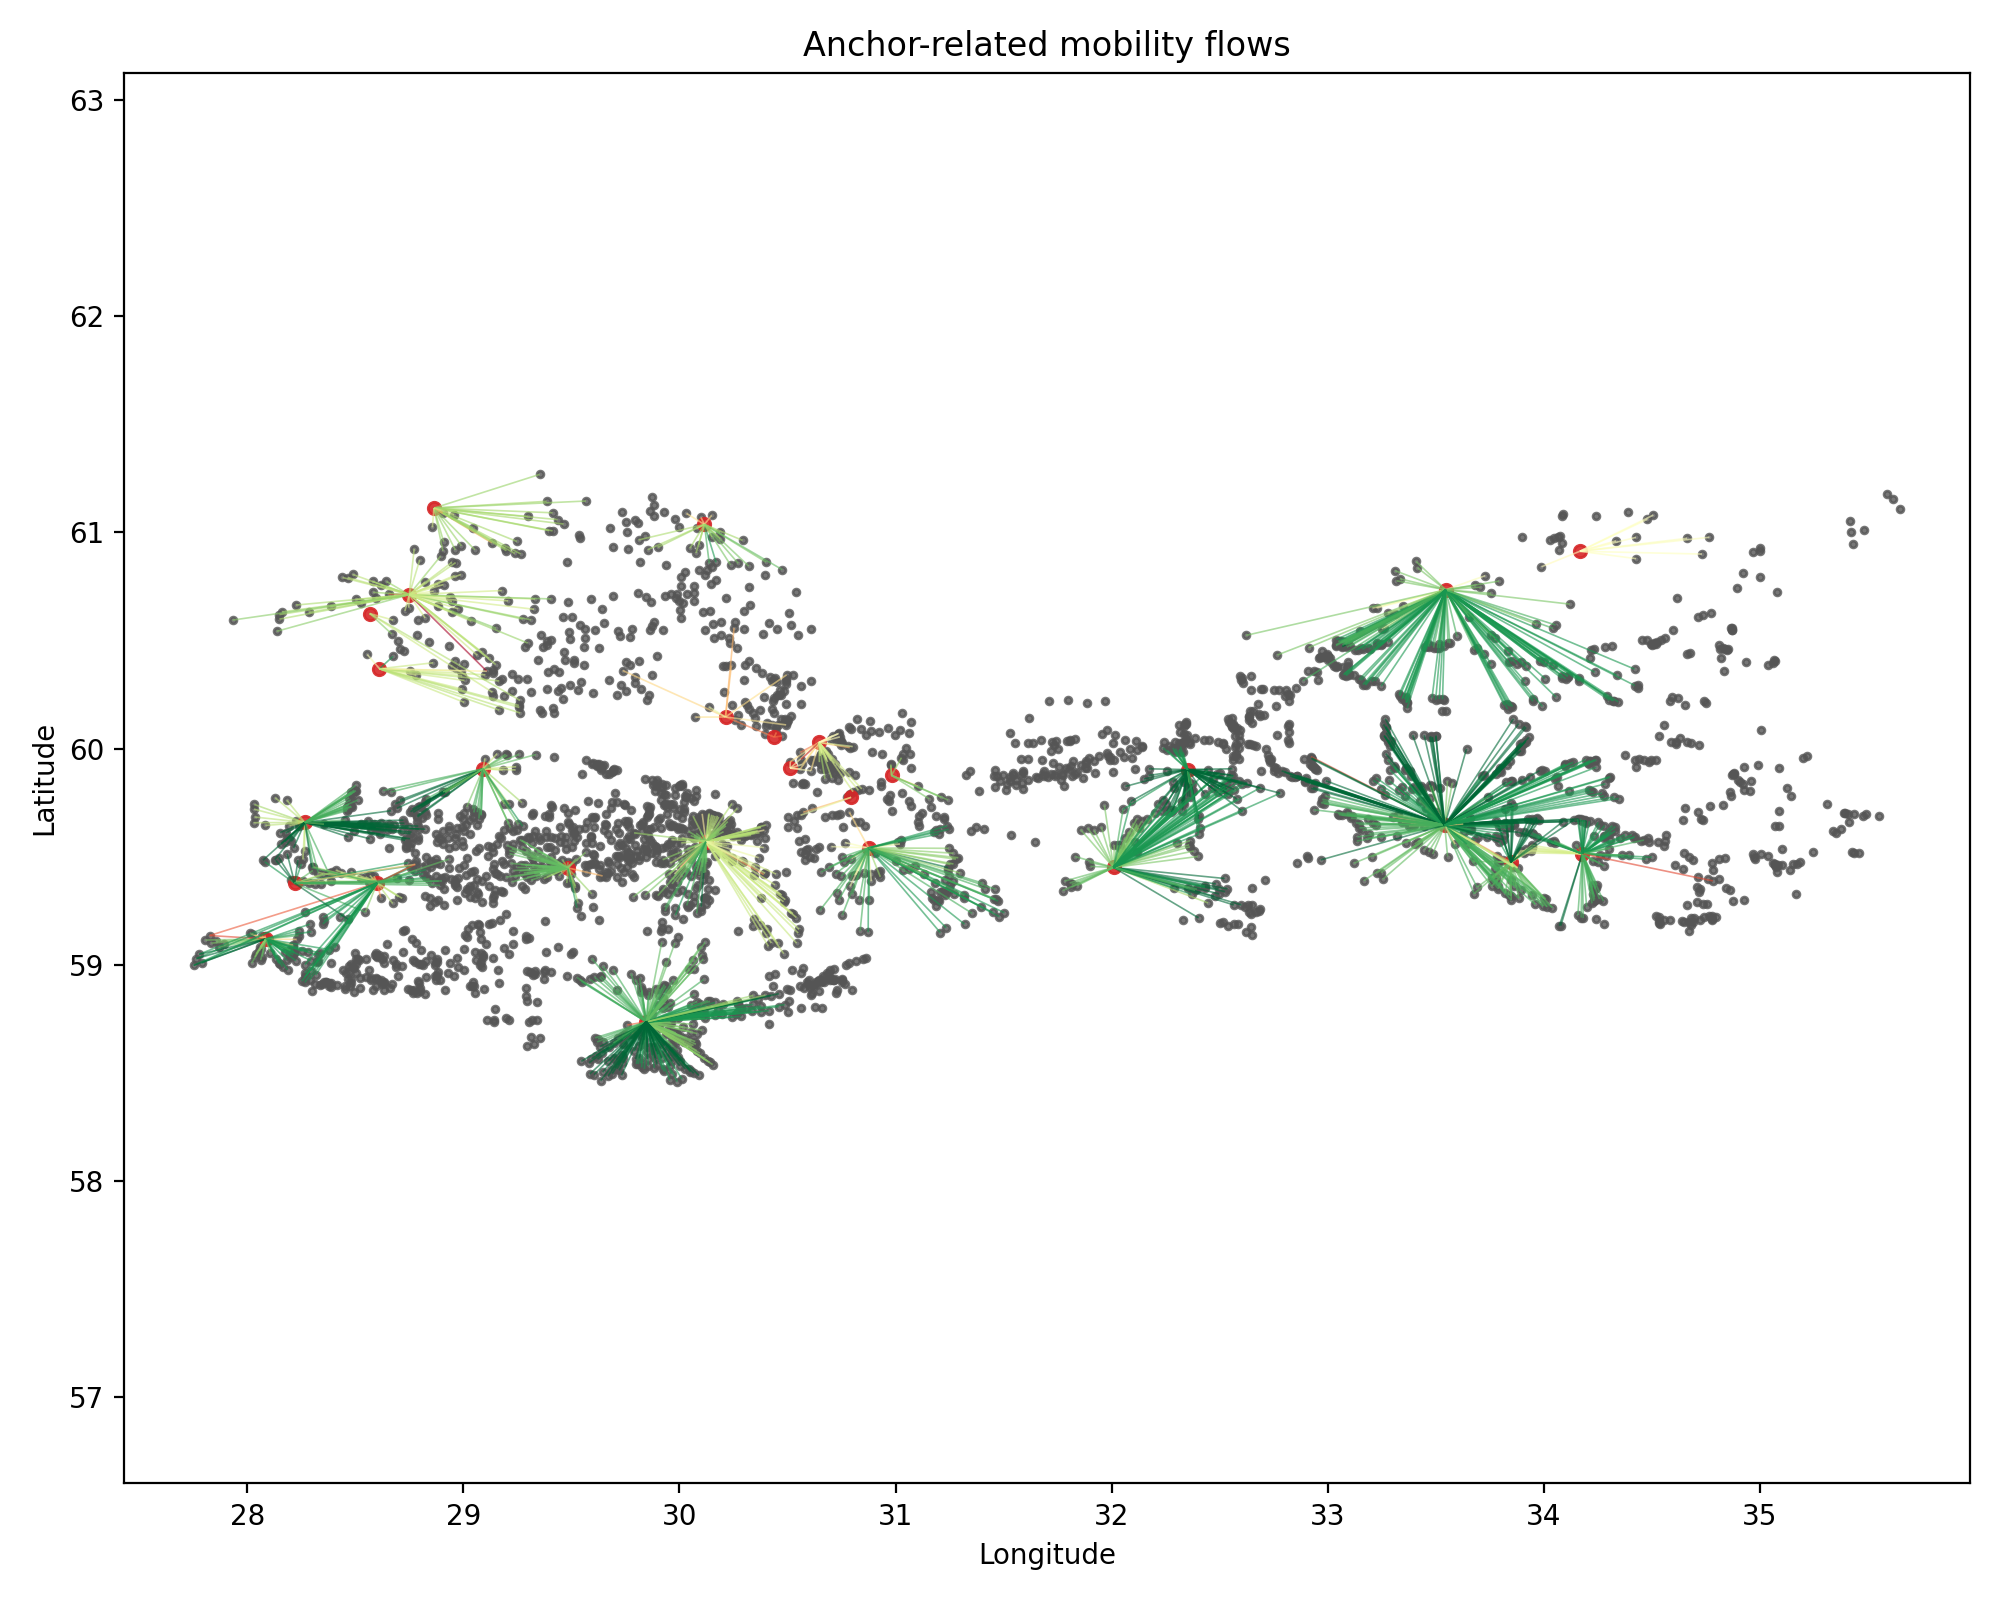

In [28]:
# 5.2) Статическая карта (PNG) как пример результата в ноутбуке
region.save_static_map_png(PNG_OUT)
from IPython.display import Image, display
display(Image(PNG_OUT))

## Сценарии: старое vs новое население
Для каждого сценария выполняем полный цикл: загружаем данные, население и опорные пункты, пересчитываем provision для всех сервисов,
затем строим матрицы перемещений, анализируем мобильность, сохраняем HTML‑карту и выводим пример city_json.

In [ ]:
from pathlib import Path
import pandas as pd

from changer_migration.model import MigrationFlowModel

DATASET_DIR = Path("data/townsnet10")
POP_CURRENT_CSV = Path("data/population.csv")
POP_FUTURE_CSV = Path("data/population_new.csv")
ANCHORS_CSV = Path("data/anchor_settlement.csv")
SERVICES_GEOJSON = Path("services.geojson")
OUTPUT_DIR_CURRENT = Path("data/provision/generated_current")
OUTPUT_DIR_FUTURE = Path("data/provision/generated_future")


def run_scenario(label: str, population_csv: Path, output_dir: Path):
    print(f"=== {label.upper()} ===")
    model = MigrationFlowModel.from_pickle(DATASET_DIR)

    population_df = pd.read_csv(population_csv)
    anchors_df = pd.read_csv(ANCHORS_CSV)
    model.update_population(population_df)
    print(f"Обновлено население: {population_df.shape[0]} записей")

    output_dir.mkdir(parents=True, exist_ok=True)
    model.calculate_provision(
        services=None,
        data_path=output_dir,
        services_source=SERVICES_GEOJSON,
    )
    print(f"Provision рассчитан и сохранён в {output_dir}")

    model.load_migration_matrix(matrix_dir=output_dir, anchors=anchors_df)
    mobility = model.analyze_mobility(anchor_threshold=90.0)
    print("Mobility рассчитан: покрытие и потенциальные опорные пункты собраны")

    json_path = output_dir / f"{label}_city.json"
    model.save_city_json(json_path, by="id")
    print(f"city_json сохранён: {json_path}")

    for city_id, payload in list(model.city_json.items())[:3]:
        print(f"city_id={city_id}: {payload['Название']}, {payload['Самообеспеченность, %']}%")

    return model, mobility


model_current, mobility_current = run_scenario("current", POP_CURRENT_CSV, OUTPUT_DIR_CURRENT)
model_future, mobility_future = run_scenario("future", POP_FUTURE_CSV, OUTPUT_DIR_FUTURE)
